Мастерская Проект Maven Cafe

Вы только что провели тест, отправив различные комбинации рекламных предложений существующим участникам программы лояльности. Теперь, когда 30-дневный период теста завершился, ваша задача — определить ключевые сегменты клиентов и разработать стратегию, основанную на данных, для будущих рекламных сообщений и таргетирования.


План работы:
1. Загрузка данных.
2. Предобработка данных:
  - обратить внимание на пропуски и специфические значения в данных
  - объединение данных
3. RFM анализ.
4. Выгрузка данных для работы в yandex datalens.
5. Промежуточные выводы.
6. Дашборд с результатами, выводами и рекомендациями.

# 1. Загрузка данных

In [ ]:
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Colab/Maven/

customers.csv  events.csv  Maven.ipynb	offers.csv


In [ ]:
df_customers = pd.read_csv('/content/drive/MyDrive/Colab/Maven/customers.csv')

# 2. Предобработка данных

In [ ]:
df_customers

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,20170715,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,20170509,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,118,NaN
...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,F,45,54000.0
16996,2cb4f97358b841b9a9773a7aa05a9d77,20180713,M,61,72000.0
16997,01d26f638c274aa0b965d24cefe3183f,20170126,M,49,73000.0
16998,9dc1421481194dcd9400aec7c9ae6366,20160307,F,83,50000.0


In [ ]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       17000 non-null  object 
 1   became_member_on  17000 non-null  int64  
 2   gender            14825 non-null  object 
 3   age               17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [ ]:
# Преобразуем даты в формат datetime
df_customers['became_member_on'] = pd.to_datetime(df_customers['became_member_on'], format='%Y%m%d')

In [ ]:
#посмотрим на пропуски в customers
df_customers.isnull().sum()

,0
customer_id,0
became_member_on,0
gender,2175
age,0
income,2175


In [ ]:
# в поле gender присутствуют пропуски, не указан пол. Удалять эти строки мы не будем, заменим на Other
df_customers['gender'] = df_customers['gender'].fillna('Other')

In [ ]:
#проверка
df_customers.isnull().sum()

,0
customer_id,0
became_member_on,0
gender,0
age,0
income,2175


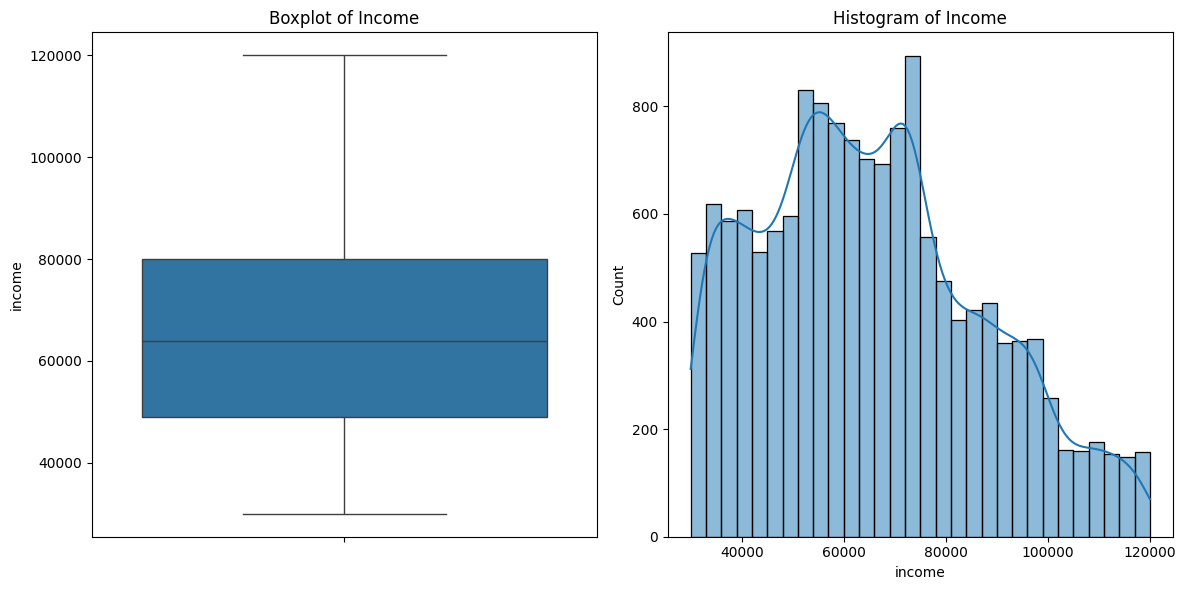

In [ ]:
#построим график по столбцу income, посмотрим на выбросы

# Создание фигуры с 2 графиками: boxplot и histogram
plt.figure(figsize=(12, 6))

# Boxplot для выявления выбросов
plt.subplot(1, 2, 1)
sns.boxplot(df_customers['income'])
plt.title('Boxplot of Income')

# Histogram для понимания распределения
plt.subplot(1, 2, 2)
sns.histplot(df_customers['income'], bins=30, kde=True)
plt.title('Histogram of Income')

plt.tight_layout()
plt.show()

In [ ]:
# Значительных выбросов нет, значит можно заменить пустые значения в столбце income медианой
median_income = df_customers['income'].median()
df_customers['income'] = df_customers['income'].fillna(median_income)

In [ ]:
#проверка
df_customers.isnull().sum()

,0
customer_id,0
became_member_on,0
gender,0
age,0
income,0


In [ ]:
df_events = pd.read_csv('/content/drive/MyDrive/Colab/Maven/events.csv')
df_events

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [ ]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  306534 non-null  object
 1   event        306534 non-null  object
 2   value        306534 non-null  object
 3   time         306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [ ]:
#посмотрим есть ли пропуски в events
df_events.isnull().sum()

,0
customer_id,0
event,0
value,0
time,0


In [ ]:
# Преобразование строкового представления словаря в словарь
df_events['value'] = df_events['value'].apply(ast.literal_eval)

In [ ]:
# Собираем все уникальные ключи из словарей в столбце 'value'
unique_keys = set()

for dict_value in df_events['value']:
    if isinstance(dict_value, dict):  # Проверяем, что это действительно словарь
        unique_keys.update(dict_value.keys())

# Выводим все уникальные ключи
print(unique_keys)


{'offer id', 'amount', 'reward', 'offer_id'}


In [ ]:
# Создание отдельных столбцов для каждого ключа в словаре
df_events['offer_id'] = df_events['value'].apply(lambda x: x.get('offer_id', None) if 'offer_id' in x else x.get('offer id', None))
df_events['reward'] = df_events['value'].apply(lambda x: x.get('reward', None))
df_events['amount'] = df_events['value'].apply(lambda x: x.get('amount', None))

#удаляем столбец value
df_events = df_events.drop(columns=['value'])

In [ ]:
#Проверяем, пустые значения оставляем.
df_events

,customer_id,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,NaN,3.53


In [ ]:
df_offers = pd.read_csv('/content/drive/MyDrive/Colab/Maven/offers.csv')
df_offers

,offer_id,offer_type,difficulty,reward,duration,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,['email'; 'mobile'; 'social']
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,['web'; 'email'; 'mobile'; 'social']
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,['web'; 'email'; 'mobile']
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,['web'; 'email'; 'mobile']
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,['web'; 'email']
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,['web'; 'email'; 'mobile'; 'social']
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,['web'; 'email'; 'mobile'; 'social']
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,['email'; 'mobile'; 'social']
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,['web'; 'email'; 'mobile'; 'social']
9,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,['web'; 'email'; 'mobile']


In [ ]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   offer_id    10 non-null     object
 1   offer_type  10 non-null     object
 2   difficulty  10 non-null     int64 
 3   reward      10 non-null     int64 
 4   duration    10 non-null     int64 
 5   channels    10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [ ]:
# Замена точки с запятой на запятую в столбце 'channels' без этого не преобразовать строку в список
df_offers['channels'] = df_offers['channels'].str.replace(';', ',')

# Преобразуем строку в список
df_offers['channels'] = df_offers['channels'].apply(ast.literal_eval)

# Создаем множество для хранения уникальных значений
unique_keys = set()

# Проходим по каждому значению в столбце 'channels'
for channels_list in df_offers['channels']:
    # Проверяем, что это действительно список (или множество)
    if isinstance(channels_list, list):  # Если элемент - это список
        unique_keys.update(channels_list)  # Обновляем множество уникальными значениями

# Выводим все уникальные ключи
print(unique_keys)

{'web', 'social', 'mobile', 'email'}


In [ ]:
# Теперь добавляем новые столбцы для каждого канала
df_offers['social'] = df_offers['channels'].apply(lambda x: 'social' in x if isinstance(x, list) else False)
df_offers['mobile'] = df_offers['channels'].apply(lambda x: 'mobile' in x if isinstance(x, list) else False)
df_offers['web'] = df_offers['channels'].apply(lambda x: 'web' in x if isinstance(x, list) else False)
df_offers['email'] = df_offers['channels'].apply(lambda x: 'email' in x if isinstance(x, list) else False)

# Удаляем столбец channels
df_offers = df_offers.drop(columns=['channels'])

In [ ]:
df_offers

,offer_id,offer_type,difficulty,reward,duration,social,mobile,web,email
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,True,True,False,True
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,True,True,True,True
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,False,True,True,True
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,False,True,True,True
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,False,False,True,True
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,True,True,True,True
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,True,True,True,True
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,True,True,False,True
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,True,True,True,True
9,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,False,True,True,True


## 2.1 Объединение данных

In [ ]:
print(df_offers.columns.tolist())

['offer_id', 'offer_type', 'difficulty', 'reward', 'duration', 'social', 'mobile', 'web', 'email']


In [ ]:
print(df_events.columns.tolist())

['customer_id', 'event', 'time', 'offer_id', 'reward', 'amount']


In [ ]:
print(df_customers.columns.tolist())

['customer_id', 'became_member_on', 'gender', 'age', 'income']


In [ ]:
# Объединяем df_events с df_offers по полю 'offer_id'
merged_events_offers = pd.merge(df_events, df_offers, on='offer_id', how='left')

# Затем объединяем полученный датафрейм с df_customers по полю 'customer_id'
final_df = pd.merge(merged_events_offers, df_customers, on='customer_id', how='left')

# Объединяем столбцы 'reward_x' и 'reward_y' в один столбец 'reward'
final_df['reward'] = final_df['reward_x'].combine_first(final_df['reward_y'])

# Удаляем лишние столбцы 'reward_x' и 'reward_y'
final_df.drop(columns=['reward_x', 'reward_y'], inplace=True)

# Выводим полученный датафрейм
final_df


,customer_id,event,time,offer_id,amount,offer_type,difficulty,duration,social,mobile,web,email,became_member_on,gender,age,income,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,bogo,5.0,7.0,False,True,True,True,2017-05-09,F,75,100000.0,5.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,discount,20.0,10.0,False,False,True,True,2017-08-04,Other,118,64000.0,5.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,discount,10.0,7.0,False,True,True,True,2018-04-26,M,68,70000.0,2.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,discount,10.0,10.0,True,True,True,True,2017-09-25,Other,118,64000.0,2.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,bogo,10.0,5.0,True,True,True,True,2017-10-02,Other,118,64000.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,M,66,47000.0,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-04-08,M,52,62000.0,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-09-22,F,63,52000.0,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-09,M,57,40000.0,NaN


In [ ]:
print(final_df.columns.tolist())

['customer_id', 'event', 'time', 'offer_id', 'amount', 'offer_type', 'difficulty', 'duration', 'social', 'mobile', 'web', 'email', 'became_member_on', 'gender', 'age', 'income', 'reward']


# 3. RFM анализ


Рассчёт показателей Recency, Frequency и Monetary

In [ ]:
# Преобразуем 'time' из часов в datetime
final_df['event_time'] = pd.to_datetime(final_df['time'], unit='h', origin='2024-01-01', errors='coerce')


# Вычисляем 'recency' на основе последнего события типа 'transaction' для каждого клиента
current_time = pd.to_datetime("2024-01-31")
last_event_time = final_df[final_df['event'] == 'transaction'].groupby('customer_id')['event_time'].max()
recency_df = (current_time - last_event_time).dt.days  # Преобразуем в дни
recency_df = recency_df.reset_index(name='recency')

# Объединяем столбец recency с основным DataFrame
final_df = final_df.merge(recency_df, on='customer_id', how='left')

# Считаем Frequency
frequency = final_df[final_df['event'] == 'transaction'].groupby('customer_id').size().reset_index(name='frequency')

# Считаем Monetary
monetary = final_df.groupby('customer_id')['reward'].sum().reset_index(name='monetary')

# Объединяем все в итоговую таблицу RFM
rfm_df = final_df[['customer_id']].drop_duplicates().merge(frequency, on='customer_id', how='left') \
                                   .merge(monetary, on='customer_id', how='left') \
                                   .merge(recency_df, on='customer_id', how='left')
rfm_df

,customer_id,frequency,monetary,recency
0,78afa995795e4d85b5d9ceeca43f5fef,7.0,60.0,7.0
1,a03223e636434f42ac4c3df47e8bac43,3.0,25.0,4.0
2,e2127556f4f64592b11af22de27a7932,3.0,25.0,8.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,32.0,NaN
4,68617ca6246f4fbc85e91a2a49552598,2.0,50.0,2.0
...,...,...,...,...
16995,9fcbff4f8d7241faa4ab8a9d19c8a812,NaN,20.0,NaN
16996,ebae5093b436466c9fbd097cb7434023,2.0,6.0,2.0
16997,912b9f623b9e4b4eb99b6dc919f09a93,NaN,20.0,NaN
16998,3045af4e98794a04a5542d3eac939b1f,NaN,20.0,NaN


Создание RFM-таблицы

In [ ]:
# Объединяем все показатели в одну таблицу
rfm_df = final_df[['customer_id', 'recency']].merge(frequency, on='customer_id', how='outer').merge(monetary, on='customer_id', how='outer')

# Просмотр итоговой таблицы RFM
print(rfm_df.head())

                        customer_id  recency  frequency  monetary
0  0009655768c64bdeb2e877511632db8f      1.0        8.0      25.0
1  0009655768c64bdeb2e877511632db8f      1.0        8.0      25.0
2  0009655768c64bdeb2e877511632db8f      1.0        8.0      25.0
3  0009655768c64bdeb2e877511632db8f      1.0        8.0      25.0
4  0009655768c64bdeb2e877511632db8f      1.0        8.0      25.0


In [ ]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  306534 non-null  object 
 1   recency      303161 non-null  float64
 2   frequency    303161 non-null  float64
 3   monetary     306534 non-null  float64
dtypes: float64(3), object(1)
memory usage: 9.4+ MB


In [ ]:
# Преобразование столбцов Recency, Frequency и Monetary в числовые типы
rfm_df['recency'] = pd.to_numeric(rfm_df['recency'], errors='coerce')
rfm_df['frequency'] = pd.to_numeric(rfm_df['frequency'], errors='coerce')
rfm_df['monetary'] = pd.to_numeric(rfm_df['monetary'], errors='coerce')

# Проверка на наличие пропусков после преобразования
print(rfm_df.isnull().sum())

customer_id       0
recency        3373
frequency      3373
monetary          0
dtype: int64


Присвоение RFM-оценок

In [ ]:
# Функция для присвоения оценок по квантилям
def rfm_score(x, column, quantiles):
    if x <= quantiles[column][0.25]:
        return 1
    elif x <= quantiles[column][0.50]:
        return 2
    elif x <= quantiles[column][0.75]:
        return 3
    else:
        return 4

# Рассчёт квантилей
quantiles = rfm_df[['recency', 'frequency', 'monetary']].quantile(q=[0.25, 0.50, 0.75]).to_dict()


# Присвоение оценок для каждой метрики
rfm_df['r_score'] = rfm_df['recency'].apply(rfm_score, args=('recency', quantiles))
rfm_df['f_score'] = rfm_df['frequency'].apply(rfm_score, args=('frequency', quantiles))
rfm_df['m_score'] = rfm_df['monetary'].apply(rfm_score, args=('monetary', quantiles))

# Объединение оценок в один RFM-индекс
rfm_df['rfm_index'] = rfm_df['r_score'].map(str) + rfm_df['f_score'].map(str) + rfm_df['m_score'].map(str)

In [ ]:
#разбиваем данные из столбца frequency по указанным в списке квартилям
pd.qcut(rfm_df['frequency'], [0, .25, .75, 1.], labels=[1, 2, 3]).value_counts()

,count
frequency,
2,137948
1,91018
3,74195


In [ ]:
# Просмотр итоговой таблицы с RFM-индексом
rfm_df.head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_index
0,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121
1,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121
2,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121
3,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121
4,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121


Создание сегментов клиентов

In [ ]:
# Определение сегментов на основе RFM-индекса
def segment_customers(row):
    if row['r_score'] == 4 and row['f_score'] == 4 and row['m_score'] == 4:
        return 'Лучшие покупатели'
    elif row['r_score'] == 3 or row['f_score'] == 3:
        return 'Лояльные покупатели'
    elif row['r_score'] == 1:
        return 'В зоне риска'
    else:
        return 'Остальные'

rfm_df['segment'] = rfm_df.apply(segment_customers, axis=1)

# Просмотр сегментов
print(rfm_df['segment'].value_counts())


segment
Лояльные покупатели    121736
Остальные               95780
В зоне риска            87826
Лучшие покупатели        1192
Name: count, dtype: int64


In [ ]:
#группируем датасет по покупателям
rfm_df.groupby('customer_id').max().reset_index()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_index,segment
0,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121,В зоне риска
1,00116118485d4dfda04fdbaba9a87b5c,10.0,3.0,20.0,4,1,1,411,Остальные
2,0011e0d4e6b944f998e987f904e8c1e5,2.0,5.0,39.0,2,1,2,212,Остальные
3,0020c2b971eb4e9188eac86d93036a77,0.0,8.0,50.0,1,2,3,123,В зоне риска
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,12.0,39.0,2,3,2,232,Лояльные покупатели
...,...,...,...,...,...,...,...,...,...
16995,fff3ba4757bd42088c044ca26d73817a,7.0,11.0,27.0,4,3,1,431,Лояльные покупатели
16996,fff7576017104bcc8677a8d63322b5e1,1.0,6.0,62.0,1,1,4,114,В зоне риска
16997,fff8957ea8b240a6b5e634b6ee8eafcf,6.0,5.0,24.0,4,1,1,411,Остальные
16998,fffad4f4828548d1b5583907f2e9906b,1.0,12.0,45.0,1,3,2,132,Лояльные покупатели


In [ ]:
# проверяем
rfm_df.groupby('customer_id')['segment'].max().value_counts()

,count
segment,
Остальные,6458
Лояльные покупатели,6100
В зоне риска,4390
Лучшие покупатели,52


In [ ]:
rfm_df

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_index,segment
0,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121,В зоне риска
1,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121,В зоне риска
2,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121,В зоне риска
3,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121,В зоне риска
4,0009655768c64bdeb2e877511632db8f,1.0,8.0,25.0,1,2,1,121,В зоне риска
...,...,...,...,...,...,...,...,...,...
306529,ffff82501cea40309d5fdd7edcca4a07,3.0,15.0,54.0,3,4,3,343,Лояльные покупатели
306530,ffff82501cea40309d5fdd7edcca4a07,3.0,15.0,54.0,3,4,3,343,Лояльные покупатели
306531,ffff82501cea40309d5fdd7edcca4a07,3.0,15.0,54.0,3,4,3,343,Лояльные покупатели
306532,ffff82501cea40309d5fdd7edcca4a07,3.0,15.0,54.0,3,4,3,343,Лояльные покупатели


In [ ]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  306534 non-null  object 
 1   recency      303161 non-null  float64
 2   frequency    303161 non-null  float64
 3   monetary     306534 non-null  float64
 4   r_score      306534 non-null  int64  
 5   f_score      306534 non-null  int64  
 6   m_score      306534 non-null  int64  
 7   rfm_index    306534 non-null  object 
 8   segment      306534 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 21.0+ MB


In [ ]:
#проверка
rfm_df['rfm_index'] = rfm_df['rfm_index'].astype(int)
filtered_data = rfm_df[rfm_df['rfm_index'] == 233]

# Вывод отфильтрованных данных
print(filtered_data)

                             customer_id  recency  frequency  monetary  \
1033    0103de989e084e0fab400e80678d7591      2.0       11.0      56.0   
1034    0103de989e084e0fab400e80678d7591      2.0       11.0      56.0   
1035    0103de989e084e0fab400e80678d7591      2.0       11.0      56.0   
1036    0103de989e084e0fab400e80678d7591      2.0       11.0      56.0   
1037    0103de989e084e0fab400e80678d7591      2.0       11.0      56.0   
...                                  ...      ...        ...       ...   
300386  fab66562e2d74078b1306d2549e90543      2.0       10.0      56.0   
300387  fab66562e2d74078b1306d2549e90543      2.0       10.0      56.0   
300388  fab66562e2d74078b1306d2549e90543      2.0       10.0      56.0   
300389  fab66562e2d74078b1306d2549e90543      2.0       10.0      56.0   
300390  fab66562e2d74078b1306d2549e90543      2.0       10.0      56.0   

        r_score  f_score  m_score  rfm_index              segment  
1033          2        3        3        23

# 4. Выгрузка данных

Выгружаем два датасета обратно на google диск для дальнейшей работой с ними в datalens

In [ ]:
output_folder = '/content/drive/MyDrive/Colab/Maven/'

#Сохраняем датасеты в формате CSV
final_df.to_csv(f"{output_folder}final_df.csv", index=False)
rfm_df.to_csv(f"{output_folder}rfm_df.csv", index=False)

# 5. Промежуточные выводы

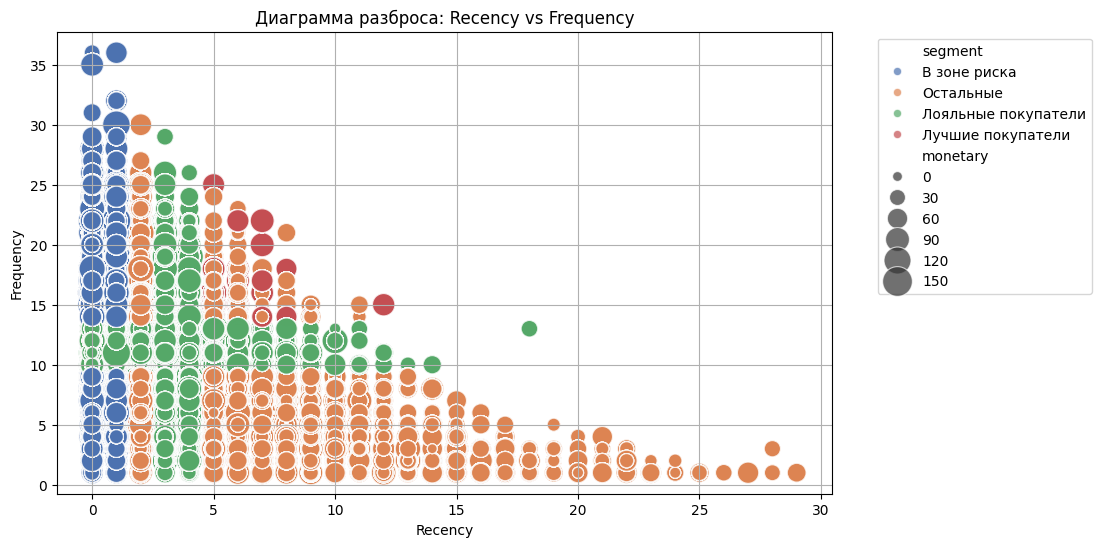

In [ ]:
# Диаграмма разброса
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='recency', y='frequency', size='monetary', hue='segment',
                sizes=(50, 500), alpha=0.7, palette='deep')
plt.title('Диаграмма разброса: Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

<ipython-input-49-b0d04d6f7730>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_df, x='segment', palette='pastel')


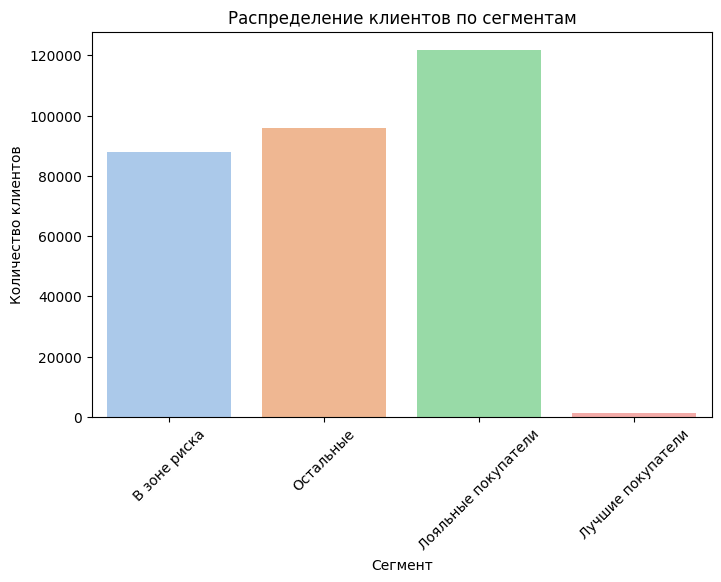

In [ ]:
# Гистограмма распределения
plt.figure(figsize=(8, 5))
sns.countplot(data=rfm_df, x='segment', palette='pastel')
plt.title('Распределение клиентов по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.show()

**Сегментация:**
* Клиенты, отмеченные синим цветом («В зоне риска»), имеют низкие значения Recency, что указывает на недавнюю активность, и более высокую частоту покупок (Frequency). Это сегмент, которому стоит уделить внимание, так как эти клиенты рискуют стать менее активными, но всё ещё показывают потенциальную ценность.
* Клиенты оранжевого цвета («Остальные») составляют основную часть данных и имеют средние или высокие значения Recency (т.е. давно не проявляли активность) при разной частоте покупок. Это группа клиентов с низкой ценностью, и они требуют мер для вовлечения.
* Зелёные точки («Лояльные покупатели») имеют сравнительно низкие значения Recency и умеренно высокие значения Frequency. Они представляют собой группу лояльных клиентов, которая демонстрирует высокую вовлеченность и стабильность в покупках.
* Красные точки («Лучшие покупатели») имеют наименьшие значения Recency и самые высокие значения Frequency. Это ключевые клиенты, которые делают покупки часто и недавно, и, вероятно, приносят наибольшую ценность бизнесу.
Зависимость между частотой покупок и давностью:

Наблюдается явная тенденция: клиенты с более низкими значениями Recency (т.е. недавно проявлявшие активность) имеют более высокую частоту покупок.
С увеличением Recency (т.е. чем дольше клиент не проявлял активность), частота покупок снижается. Это указывает на то, что длительное отсутствие активности связано с меньшей лояльностью и, возможно, с переходом клиента в «спящий» статус.

**Сумма покупок:**
* Размер точек соответствует значению Monetary (средняя сумма покупок или ценность клиента). Крупные точки сконцентрированы среди лояльных и лучших покупателей (зелёный и красный цвета), что подтверждает их высокую ценность для компании.
* У клиентов «в зоне риска» (синий цвет) также есть несколько крупных точек, что указывает на их высокую ценность, несмотря на потенциальный риск снижения активности.
* В группе «остальных» точки преимущественно маленькие, что указывает на низкие значения Monetary.

**Рекомендации:**

* Сегмент «Лучшие покупатели»: Продолжать стимулировать их активность с помощью персонализированных предложений и программ лояльности.
* Сегмент «В зоне риска»: Проводить кампании для их удержания, чтобы предотвратить возможное снижение активности. Это могут быть специальные предложения для возвращения или скидки.
* Сегмент «Лояльные покупатели»: Сфокусироваться на их удержании и повышении ценности через кросс-продажи.
* Сегмент «Остальные»: Применять стратегии для активации клиентов и увеличения частоты покупок, либо провести анализ для фокусировки на более ценных клиентах, если бюджет ограничен.

**Выводы:**
На графике видно, что клиенты с более высокой частотой покупок и меньшей давностью приносят большую ценность.

Поэтому основное внимание стоит уделить их удержанию и поддержанию их интереса.

# 6. Дашборд

[ссылка](https://datalens.yandex/o0tp5sh7p1p2b)